In [1]:
import pandas as pd
import random
from prepare_data import preprocess_data_czech
from eval import comapre_unidist_cont, compute_ngram_metrics, comapre_unidist_cat, compute_2d_categorical_metrics
import datetime
import calendar
import numpy as np
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_rows', 100)

2024-03-11 09:04:33.377690: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


## real data

### Entire Data

In [2]:
real = pd.read_csv('../DATA/tr_by_acct_w_age.csv')
real = real.sort_values(by = ["account_id", "date"])
raw_data, LOG_AMOUNT_SCALE, TD_SCALE = preprocess_data_czech(real)

In [3]:
all_real = raw_data[['account_id', 'tcode', 'datetime', 'amount', 'td', 'day', 'month', 'year','age']]
all_real['type'] = all_real['tcode'].str.split('__').str[0]
all_real['raw_amount'] = all_real.apply(lambda row: row['amount'] if row['type'] == 'CREDIT' else -row['amount'], axis=1)
all_real_cf = all_real[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()


/users/fs2/hmehri/miniconda3/envs/mainenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/users/fs2/hmehri/miniconda3/envs/mainenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
TCODE_TO_NUM = dict([(tc, i) for i, tc in enumerate(all_real.tcode.unique())])
NUM_TO_TCODE = dict([(i, tc) for i, tc in enumerate(all_real.tcode.unique())]) 
tcode_nums_r = all_real["tcode"].apply(lambda x: TCODE_TO_NUM[x])
n_tcodes = len(TCODE_TO_NUM)
oh_r = tf.one_hot(tcode_nums_r, depth = n_tcodes)
data_r = np.concatenate([np.array(all_real["amount"])[:,None], oh_r.numpy()], axis=1)
tcode_names = [NUM_TO_TCODE[i] for i in range(n_tcodes)]
data_r.shape

2024-03-11 09:07:37.857506: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-03-11 09:07:37.858838: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-03-11 09:07:37.892546: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.45GiB deviceMemoryBandwidth: 625.94GiB/s
2024-03-11 09:07:37.892718: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:af:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.45GiB deviceMemoryBandwidth: 625.94GiB/s
2024-03-11 09:07:37.892735: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-03-11 09:0

(1056320, 17)

In [115]:
real_trans_df = pd.DataFrame.from_records(data_r, columns=["amount"] + tcode_names)
real_trans_df["account_id"] = all_real["account_id"]
#real_trans_df["age"] = all_real["age"]
real_trans_df["log_amount"] = np.log10(real_trans_df["amount"]+1)

AMOUNT_SCALE = real_trans_df["amount"].std()
LOG_AMOUNT_SCALE = real_trans_df["log_amount"].std()

real_trans_df["amount_sc"] = real_trans_df["amount"] / AMOUNT_SCALE
real_trans_df["log_amount_sc"] = real_trans_df["log_amount"] / LOG_AMOUNT_SCALE

real_trans_df["days_passed"] = all_real["td"]

real_trans_df

,amount,CREDIT__CREDIT IN CASH__nan,CREDIT__COLLECTION FROM ANOTHER BANK__nan,CREDIT__nan__INTEREST CREDITED,DEBIT__CASH WITHDRAWAL__nan,DEBIT__CASH WITHDRAWAL__PAYMENT ON STATEMENT,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,DEBIT__REMITTANCE TO ANOTHER BANK__LOAN PAYMENT,DEBIT__REMITTANCE TO ANOTHER BANK__,DEBIT__REMITTANCE TO ANOTHER BANK__INSURANCE PAYMENT,...,DEBIT__REMITTANCE TO ANOTHER BANK__nan,DEBIT__CASH WITHDRAWAL__HOUSEHOLD,DEBIT__CASH WITHDRAWAL__SANCTION INTEREST,DEBIT__CASH WITHDRAWAL__,DEBIT__CASH WITHDRAWAL__INSURANCE PAYMENT,account_id,log_amount,amount_sc,log_amount_sc,days_passed
0,1000.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,3.000434,0.105012,2.823750,0.0
1,3679.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,3.565848,0.386339,3.355869,20.0
2,12600.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,4.100405,1.323149,3.858949,10.0
3,19.2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,1.305351,0.002016,1.228484,7.0
4,3679.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,3.565848,0.386339,3.355869,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1056315,25600.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11382,4.408257,2.688303,4.148672,2.0
1056316,46248.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11382,4.665102,4.856588,4.390393,8.0
1056317,6300.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11382,3.799409,0.661575,3.575677,15.0
1056318,311.3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11382,2.494572,0.032690,2.347677,6.0


### recurring transactions

In [37]:
rec_tcodes = ['DEBIT__CASH WITHDRAWAL__PAYMENT ON STATEMENT', 'CREDIT__nan__INTEREST CREDITED', 'DEBIT__REMITTANCE TO ANOTHER BANK__nan', 
                    'DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD',  'CREDIT__COLLECTION FROM ANOTHER BANK__nan', 'DEBIT__REMITTANCE TO ANOTHER BANK__ ', 
                    'DEBIT__REMITTANCE TO ANOTHER BANK__INSURANCE PAYMENT', 'DEBIT__REMITTANCE TO ANOTHER BANK__LOAN PAYMENT', 
                     'CREDIT__COLLECTION FROM ANOTHER BANK__OLD AGE PENSION']
def calculate_days_passed(group):
    group['days_passed'] = group['datetime'].diff().fillna(pd.Timedelta(seconds=0)).dt.days
    group['days_passed'] = group['days_passed'].fillna(0).astype(int)  # Fill NaN values with 0 for the first transaction
    return group

In [ ]:
rec_real = all_real[all_real['tcode'].isin(rec_tcodes)]
rec_real_cf = rec_real[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()

In [ ]:
rec_real_sorted = rec_real.sort_values(by=['account_id', 'tcode', 'datetime'])
rec_real_sorted_final = rec_real_sorted.groupby(['account_id', 'tcode'], as_index=False).apply(calculate_days_passed)
rec_real_sorted_final.reset_index(drop=True, inplace = True)
rec_real_sorted_final[:80]

In [ ]:
TCODE_TO_NUM_rec = dict([(tc, i) for i, tc in enumerate(rec_tcodes)])
NUM_TO_TCODE_rec = dict([(i, tc) for i, tc in enumerate(rec_tcodes)]) 
tcode_nums_r_rec = rec_real_sorted_final["tcode"].apply(lambda x: TCODE_TO_NUM_rec[x])
n_tcodes_rec = len(TCODE_TO_NUM_rec)
oh_r_rec = tf.one_hot(tcode_nums_r_rec, depth = n_tcodes_rec)
data_r_rec = np.concatenate([np.array(rec_real_sorted_final["amount"])[:,None], oh_r_rec.numpy()], axis=1)
tcode_names_rec = [NUM_TO_TCODE_rec[i] for i in range(n_tcodes_rec)]
data_r_rec.shape

In [ ]:
real_rec_trans_df = pd.DataFrame.from_records(data_r_rec, columns=["amount"] + tcode_names_rec)
real_rec_trans_df.reset_index(drop=True, inplace=True)
rec_real_sorted_final.reset_index(drop=True, inplace=True)
real_rec_trans_df["account_id"] = rec_real_sorted_final["account_id"]
#real_trans_df["age"] = all_real["age"]
real_rec_trans_df["log_amount"] = np.log10(real_rec_trans_df["amount"]+1)

AMOUNT_SCALE_rec = real_rec_trans_df["amount"].std()
LOG_AMOUNT_SCALE_rec = real_rec_trans_df["log_amount"].std()

real_rec_trans_df["amount_sc"] = real_rec_trans_df["amount"] / AMOUNT_SCALE_rec
real_rec_trans_df["log_amount_sc"] = real_rec_trans_df["log_amount"] / LOG_AMOUNT_SCALE_rec

real_rec_trans_df["days_passed"] = rec_real_sorted_final["days_passed"]

real_rec_trans_df

### non-recurring

In [ ]:
norec_tcodes = ['DEBIT__CASH WITHDRAWAL__ ', 'DEBIT__CASH WITHDRAWAL__nan', 
                       'DEBIT__CASH WITHDRAWAL__HOUSEHOLD', 'DEBIT__CASH WITHDRAWAL__SANCTION INTEREST',  'DEBIT__CREDIT CARD WITHDRAWAL__nan',  
                        'DEBIT__CASH WITHDRAWAL__INSURANCE PAYMENT', 'CREDIT__CREDIT IN CASH__nan']

In [6]:
norec_real = all_real[all_real['tcode'].isin(norec_tcodes)]
norec_real_cf = norec_real[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()

In [ ]:
norec_real_sorted = norec_real.sort_values(by=['account_id', 'tcode', 'datetime'])
norec_real_sorted_final = norec_real_sorted.groupby(['account_id', 'tcode'], as_index=False).apply(calculate_days_passed)
norec_real_sorted_final.reset_index(drop=True, inplace = True)
norec_real_sorted_final[:80]

In [55]:
TCODE_TO_NUM_norec = dict([(tc, i) for i, tc in enumerate(norec_tcodes)])
NUM_TO_TCODE_norec = dict([(i, tc) for i, tc in enumerate(norec_tcodes)]) 
tcode_nums_r_norec = norec_real_sorted_final["tcode"].apply(lambda x: TCODE_TO_NUM_norec[x])
n_tcodes_norec = len(TCODE_TO_NUM_norec)
oh_r_norec = tf.one_hot(tcode_nums_r_norec, depth = n_tcodes_norec)
data_r_norec = np.concatenate([np.array(norec_real_sorted_final["amount"])[:,None], oh_r_norec.numpy()], axis=1)
tcode_names_norec = [NUM_TO_TCODE_norec[i] for i in range(n_tcodes_norec)]
data_r_norec.shape

(443865, 8)

In [56]:
real_norec_trans_df = pd.DataFrame.from_records(data_r_norec, columns=["amount"] + tcode_names_norec)
real_norec_trans_df.reset_index(drop=True, inplace=True)
norec_real_sorted_final.reset_index(drop=True, inplace=True)
real_norec_trans_df["account_id"] = norec_real_sorted_final["account_id"]
#real_trans_df["age"] = all_real["age"]
real_norec_trans_df["log_amount"] = np.log10(real_norec_trans_df["amount"]+1)

AMOUNT_SCALE_norec = real_norec_trans_df["amount"].std()
LOG_AMOUNT_SCALE_norec = real_norec_trans_df["log_amount"].std()

real_norec_trans_df["amount_sc"] = real_norec_trans_df["amount"] / AMOUNT_SCALE_norec
real_norec_trans_df["log_amount_sc"] = real_norec_trans_df["log_amount"] / LOG_AMOUNT_SCALE_norec

real_norec_trans_df["days_passed"] = norec_real_sorted_final["days_passed"]

real_norec_trans_df

,amount,DEBIT__CASH WITHDRAWAL__,DEBIT__CASH WITHDRAWAL__nan,DEBIT__CASH WITHDRAWAL__HOUSEHOLD,DEBIT__CASH WITHDRAWAL__SANCTION INTEREST,DEBIT__CREDIT CARD WITHDRAWAL__nan,DEBIT__CASH WITHDRAWAL__INSURANCE PAYMENT,CREDIT__CREDIT IN CASH__nan,account_id,log_amount,amount_sc,log_amount_sc,days_passed
0,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,3.000434,0.089512,5.187717,0
1,12600.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,4.100405,1.127855,7.089554,30
2,2100.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,3.322426,0.187976,5.744437,30
3,100.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,2.004321,0.008951,3.465449,270
4,200.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1,2.303196,0.017902,3.982200,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
443860,23000.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11382,4.361747,2.058782,7.541411,30
443861,9000.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11382,3.954291,0.805610,6.836924,11
443862,18900.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11382,4.276485,1.691782,7.393994,19
443863,25600.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11382,4.408257,2.291514,7.621827,30


## Banksformer

## Entire data

In [57]:
all_synthbf = pd.read_csv('../Banksformer/synth_banksformer_type1_clock.csv')
all_synthbf.rename(columns={'days_passed': 'td', 'date':'datetime'}, inplace=True)
all_synthbf['type'] = all_synthbf['tcode'].str.split('__').str[0]
all_synthbf['raw_amount'] = all_synthbf.apply(lambda row: row['amount'] if row['type'] == 'CREDIT' else -row['amount'], axis=1)
all_synthbf_cf = all_synthbf[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()

all_synthbf

,amount,tcode,account_id,year,month,day,datetime,td,type,raw_amount
0,1083.11,DEBIT__CASH WITHDRAWAL__nan,0,1995,8,26,1995-08-26,0,DEBIT,-1083.11
1,110.81,CREDIT__nan__INTEREST CREDITED,0,1995,8,31,1995-08-31,5,CREDIT,110.81
2,13.78,DEBIT__CASH WITHDRAWAL__PAYMENT ON STATEMENT,0,1995,8,31,1995-08-31,0,DEBIT,-13.78
3,2640.54,CREDIT__CREDIT IN CASH__nan,0,1995,9,1,1995-09-01,1,CREDIT,2640.54
4,2570.90,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,0,1995,9,8,1995-09-08,7,DEBIT,-2570.90
...,...,...,...,...,...,...,...,...,...,...
399995,12.45,DEBIT__CASH WITHDRAWAL__PAYMENT ON STATEMENT,4999,1994,11,30,1994-11-30,18,DEBIT,-12.45
399996,75.43,CREDIT__nan__INTEREST CREDITED,4999,1994,11,30,1994-11-30,0,CREDIT,75.43
399997,291.68,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,4999,1994,12,8,1994-12-08,8,DEBIT,-291.68
399998,4171.42,CREDIT__COLLECTION FROM ANOTHER BANK__nan,4999,1994,12,10,1994-12-10,2,CREDIT,4171.42


In [58]:
tcode_nums_synthbf = all_synthbf["tcode"].apply(lambda x: TCODE_TO_NUM[x])
n_tcodes = len(TCODE_TO_NUM)
oh_synthbf = tf.one_hot(tcode_nums_synthbf, depth = n_tcodes)
data_synthbf = np.concatenate([np.array(all_synthbf["amount"])[:,None], oh_synthbf.numpy()], axis=1)
tcode_names = [NUM_TO_TCODE[i] for i in range(n_tcodes)]
data_synthbf.shape

(400000, 17)

In [59]:
synthbf_trans_df = pd.DataFrame.from_records(data_synthbf, columns=["amount"] + tcode_names)
synthbf_trans_df["account_id"] = all_synthbf["account_id"]
#real_trans_df["age"] = all_real["age"]
synthbf_trans_df["log_amount"] = np.log10(synthbf_trans_df["amount"]+1)

AMOUNT_SCALE = synthbf_trans_df["amount"].std()
LOG_AMOUNT_SCALE = synthbf_trans_df["log_amount"].std()

synthbf_trans_df["amount_sc"] = synthbf_trans_df["amount"] / AMOUNT_SCALE
synthbf_trans_df["log_amount_sc"] = synthbf_trans_df["log_amount"] / LOG_AMOUNT_SCALE

synthbf_trans_df["days_passed"] = all_synthbf["td"]

synthbf_trans_df

,amount,CREDIT__CREDIT IN CASH__nan,CREDIT__COLLECTION FROM ANOTHER BANK__nan,CREDIT__nan__INTEREST CREDITED,DEBIT__CASH WITHDRAWAL__nan,DEBIT__CASH WITHDRAWAL__PAYMENT ON STATEMENT,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,DEBIT__REMITTANCE TO ANOTHER BANK__LOAN PAYMENT,DEBIT__REMITTANCE TO ANOTHER BANK__,DEBIT__REMITTANCE TO ANOTHER BANK__INSURANCE PAYMENT,...,DEBIT__REMITTANCE TO ANOTHER BANK__nan,DEBIT__CASH WITHDRAWAL__HOUSEHOLD,DEBIT__CASH WITHDRAWAL__SANCTION INTEREST,DEBIT__CASH WITHDRAWAL__,DEBIT__CASH WITHDRAWAL__INSURANCE PAYMENT,account_id,log_amount,amount_sc,log_amount_sc,days_passed
0,1083.11,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,3.035073,0.477237,3.325610,0
1,110.81,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,2.048481,0.048825,2.244574,5
2,13.78,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,1.169674,0.006072,1.281643,0
3,2640.54,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,3.421857,1.163467,3.749419,1
4,2570.90,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,3.410254,1.132783,3.736705,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,12.45,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4999,1.128722,0.005486,1.236771,18
399996,75.43,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4999,1.883264,0.033236,2.063542,0
399997,291.68,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4999,2.466393,0.128519,2.702492,8
399998,4171.42,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4999,3.620388,1.837999,3.966954,2


### recurring transactions

In [60]:
rec_synthbf = all_synthbf[all_synthbf['tcode'].isin(rec_tcodes)]
rec_synthbf_cf = rec_synthbf[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()


In [63]:
rec_synthbf_sorted = rec_synthbf.sort_values(by=['account_id', 'tcode', 'datetime'])
rec_synthbf_sorted

,amount,tcode,account_id,year,month,day,datetime,td,type,raw_amount
1,110.81,CREDIT__nan__INTEREST CREDITED,0,1995,8,31,1995-08-31,5,CREDIT,110.81
13,99.61,CREDIT__nan__INTEREST CREDITED,0,1995,9,30,1995-09-30,11,CREDIT,99.61
23,94.45,CREDIT__nan__INTEREST CREDITED,0,1995,10,31,1995-10-31,17,CREDIT,94.45
35,96.35,CREDIT__nan__INTEREST CREDITED,0,1995,11,30,1995-11-30,11,CREDIT,96.35
50,54.25,CREDIT__nan__INTEREST CREDITED,0,1995,12,31,1995-12-31,2,CREDIT,54.25
...,...,...,...,...,...,...,...,...,...,...
399976,424.36,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,4999,1994,8,8,1994-08-08,8,DEBIT,-424.36
399982,318.82,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,4999,1994,9,8,1994-09-08,1,DEBIT,-318.82
399987,310.80,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,4999,1994,10,8,1994-10-08,8,DEBIT,-310.80
399992,368.99,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,4999,1994,11,8,1994-11-08,8,DEBIT,-368.99


In [ ]:
rec_synthbf['datetime'] = pd.to_datetime(rec_synthbf['datetime'])
rec_synthbf_sorted = rec_synthbf.sort_values(by=['account_id', 'tcode', 'datetime'])
rec_synthbf_sorted_final = rec_synthbf_sorted.groupby(['account_id', 'tcode'], as_index=False).apply(calculate_days_passed)
rec_synthbf_sorted_final.reset_index(drop=True, inplace = True)
rec_synthbf_sorted_final[:80]

In [67]:
tcode_nums_synthbf_rec = rec_synthbf_sorted_final["tcode"].apply(lambda x: TCODE_TO_NUM_rec[x])
n_tcodes_rec = len(TCODE_TO_NUM_rec)
oh_synthbf_rec = tf.one_hot(tcode_nums_synthbf_rec, depth = n_tcodes_rec)
data_synthbf_rec = np.concatenate([np.array(rec_synthbf_sorted_final["amount"])[:,None], oh_synthbf_rec.numpy()], axis=1)
tcode_names_rec = [NUM_TO_TCODE_rec[i] for i in range(n_tcodes_rec)]
data_synthbf_rec.shape

(229229, 10)

In [69]:
synthbf_rec_trans_df = pd.DataFrame.from_records(data_synthbf_rec, columns=["amount"] + tcode_names_rec)
synthbf_rec_trans_df["account_id"] = rec_synthbf_sorted_final["account_id"]
#real_trans_df["age"] = all_real["age"]
synthbf_rec_trans_df["log_amount"] = np.log10(synthbf_rec_trans_df["amount"]+1)

AMOUNT_SCALE_recbf = synthbf_rec_trans_df["amount"].std()
LOG_AMOUNT_SCALE_recbf = synthbf_rec_trans_df["log_amount"].std()

synthbf_rec_trans_df["amount_sc"] = synthbf_rec_trans_df["amount"] / AMOUNT_SCALE_recbf
synthbf_rec_trans_df["log_amount_sc"] = synthbf_rec_trans_df["log_amount"] / LOG_AMOUNT_SCALE_recbf

synthbf_rec_trans_df["days_passed"] = rec_synthbf_sorted_final["days_passed"]

synthbf_rec_trans_df

,amount,DEBIT__CASH WITHDRAWAL__PAYMENT ON STATEMENT,CREDIT__nan__INTEREST CREDITED,DEBIT__REMITTANCE TO ANOTHER BANK__nan,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,CREDIT__COLLECTION FROM ANOTHER BANK__nan,DEBIT__REMITTANCE TO ANOTHER BANK__,DEBIT__REMITTANCE TO ANOTHER BANK__INSURANCE PAYMENT,DEBIT__REMITTANCE TO ANOTHER BANK__LOAN PAYMENT,CREDIT__COLLECTION FROM ANOTHER BANK__OLD AGE PENSION,account_id,log_amount,amount_sc,log_amount_sc,days_passed
0,110.81,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2.048481,0.067931,2.444547,0
1,99.61,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2.002641,0.061065,2.389844,30
2,94.45,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.979776,0.057902,2.362558,31
3,96.35,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.988336,0.059067,2.372773,30
4,54.25,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.742332,0.033258,2.079206,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229224,424.36,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4999,2.628757,0.260151,3.137017,31
229225,318.82,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4999,2.504906,0.195451,2.989220,31
229226,310.80,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4999,2.493876,0.190534,2.976058,30
229227,368.99,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4999,2.568190,0.226207,3.064740,31


### non-recurring

In [72]:
norec_synthbf = all_synthbf[all_synthbf['tcode'].isin(norec_tcodes)]
norec_synthbf_cf = norec_synthbf[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()


In [73]:
norec_synthbf_sorted = norec_synthbf.sort_values(by=['account_id', 'tcode', 'datetime'])
norec_synthbf_sorted

,amount,tcode,account_id,year,month,day,datetime,td,type,raw_amount
3,2640.54,CREDIT__CREDIT IN CASH__nan,0,1995,9,1,1995-09-01,1,CREDIT,2640.54
7,6232.45,CREDIT__CREDIT IN CASH__nan,0,1995,9,12,1995-09-12,0,CREDIT,6232.45
9,4753.70,CREDIT__CREDIT IN CASH__nan,0,1995,9,13,1995-09-13,0,CREDIT,4753.70
19,10131.22,CREDIT__CREDIT IN CASH__nan,0,1995,10,13,1995-10-13,0,CREDIT,10131.22
29,7587.01,CREDIT__CREDIT IN CASH__nan,0,1995,11,12,1995-11-12,2,CREDIT,7587.01
...,...,...,...,...,...,...,...,...,...,...
399956,2458.59,DEBIT__CASH WITHDRAWAL__nan,4999,1994,4,21,1994-04-21,9,DEBIT,-2458.59
399962,2578.17,DEBIT__CASH WITHDRAWAL__nan,4999,1994,5,22,1994-05-22,10,DEBIT,-2578.17
399968,2458.32,DEBIT__CASH WITHDRAWAL__nan,4999,1994,6,22,1994-06-22,10,DEBIT,-2458.32
399981,387.74,DEBIT__CASH WITHDRAWAL__nan,4999,1994,9,7,1994-09-07,7,DEBIT,-387.74


In [74]:
norec_synthbf['datetime'] = pd.to_datetime(norec_synthbf['datetime'])
norec_synthbf_sorted = norec_synthbf.sort_values(by=['account_id', 'tcode', 'datetime'])
norec_synthbf_sorted_final = norec_synthbf_sorted.groupby(['account_id', 'tcode'], as_index=False).apply(calculate_days_passed)
norec_synthbf_sorted_final.reset_index(drop=True, inplace = True)
norec_synthbf_sorted_final[:80]

/users/fs2/hmehri/miniconda3/envs/mainenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,amount,tcode,account_id,year,month,day,datetime,td,type,raw_amount,days_passed
0,2640.54,CREDIT__CREDIT IN CASH__nan,0,1995,9,1,1995-09-01,1,CREDIT,2640.54,0
1,6232.45,CREDIT__CREDIT IN CASH__nan,0,1995,9,12,1995-09-12,0,CREDIT,6232.45,11
2,4753.70,CREDIT__CREDIT IN CASH__nan,0,1995,9,13,1995-09-13,0,CREDIT,4753.70,1
3,10131.22,CREDIT__CREDIT IN CASH__nan,0,1995,10,13,1995-10-13,0,CREDIT,10131.22,30
4,7587.01,CREDIT__CREDIT IN CASH__nan,0,1995,11,12,1995-11-12,2,CREDIT,7587.01,30
5,11140.43,CREDIT__CREDIT IN CASH__nan,0,1995,12,12,1995-12-12,0,CREDIT,11140.43,30
6,7492.30,CREDIT__CREDIT IN CASH__nan,0,1996,1,12,1996-01-12,0,CREDIT,7492.30,31
7,6833.78,CREDIT__CREDIT IN CASH__nan,0,1996,2,12,1996-02-12,2,CREDIT,6833.78,31
8,4066.77,CREDIT__CREDIT IN CASH__nan,0,1996,3,12,1996-03-12,3,CREDIT,4066.77,29
9,1083.11,DEBIT__CASH WITHDRAWAL__nan,0,1995,8,26,1995-08-26,0,DEBIT,-1083.11,0


In [75]:
tcode_nums_synthbf_norec = norec_synthbf_sorted_final["tcode"].apply(lambda x: TCODE_TO_NUM_norec[x])
n_tcodes_norec = len(TCODE_TO_NUM_norec)
oh_synthbf_norec = tf.one_hot(tcode_nums_synthbf_norec, depth = n_tcodes_norec)
data_synthbf_norec = np.concatenate([np.array(norec_synthbf_sorted_final["amount"])[:,None], oh_synthbf_norec.numpy()], axis=1)
tcode_names_norec = [NUM_TO_TCODE_norec[i] for i in range(n_tcodes_norec)]
data_synthbf_norec.shape

(170771, 8)

In [76]:
synthbf_norec_trans_df = pd.DataFrame.from_records(data_synthbf_norec, columns=["amount"] + tcode_names_norec)
synthbf_norec_trans_df["account_id"] = norec_synthbf_sorted_final["account_id"]
#real_trans_df["age"] = all_real["age"]
synthbf_norec_trans_df["log_amount"] = np.log10(synthbf_norec_trans_df["amount"]+1)

AMOUNT_SCALE_norecbf = synthbf_norec_trans_df["amount"].std()
LOG_AMOUNT_SCALE_norecbf = synthbf_norec_trans_df["log_amount"].std()

synthbf_norec_trans_df["amount_sc"] = synthbf_norec_trans_df["amount"] / AMOUNT_SCALE_norecbf
synthbf_norec_trans_df["log_amount_sc"] = synthbf_norec_trans_df["log_amount"] / LOG_AMOUNT_SCALE_norecbf

synthbf_norec_trans_df["days_passed"] = norec_synthbf_sorted_final["days_passed"]

synthbf_norec_trans_df

,amount,DEBIT__CASH WITHDRAWAL__,DEBIT__CASH WITHDRAWAL__nan,DEBIT__CASH WITHDRAWAL__HOUSEHOLD,DEBIT__CASH WITHDRAWAL__SANCTION INTEREST,DEBIT__CREDIT CARD WITHDRAWAL__nan,DEBIT__CASH WITHDRAWAL__INSURANCE PAYMENT,CREDIT__CREDIT IN CASH__nan,account_id,log_amount,amount_sc,log_amount_sc,days_passed
0,2640.54,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,3.421857,1.127999,10.348881,0
1,6232.45,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,3.794728,2.662410,11.476573,11
2,4753.70,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,3.677123,2.030710,11.120893,1
3,10131.22,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,4.005705,4.327907,12.114638,30
4,7587.01,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,3.880128,3.241058,11.734850,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
170766,2458.59,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4999,3.390863,1.050273,10.255143,66
170767,2578.17,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4999,3.411480,1.101356,10.317497,31
170768,2458.32,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4999,3.390815,1.050158,10.254999,31
170769,387.74,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4999,2.589659,0.165637,7.832026,77


## Stackedlstm


### Entire data

In [77]:
all_synthlstm = pd.read_csv('../lstmModel/synth_lstm_type1_clock.csv')
all_synthlstm.rename(columns={'days_passed': 'td', 'date':'datetime', 'transaction_code': 'tcode'}, inplace=True)
all_synthlstm['type'] = all_synthlstm['tcode'].str.split('__').str[0]
all_synthlstm['raw_amount'] = all_synthlstm.apply(lambda row: row['amount'] if row['type'] == 'CREDIT' else -row['amount'], axis=1)
all_synthlstm_cf = all_synthbf[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()


In [78]:
tcode_nums_synthlstm = all_synthlstm["tcode"].apply(lambda x: TCODE_TO_NUM[x])
n_tcodes = len(TCODE_TO_NUM)
oh_synthlstm = tf.one_hot(tcode_nums_synthlstm, depth = n_tcodes)
data_synthlstm = np.concatenate([np.array(all_synthlstm["amount"])[:,None], oh_synthlstm.numpy()], axis=1)
tcode_names = [NUM_TO_TCODE[i] for i in range(n_tcodes)]
data_synthlstm.shape

(400000, 17)

In [79]:
synthlstm_trans_df = pd.DataFrame.from_records(data_synthlstm, columns=["amount"] + tcode_names)
synthlstm_trans_df["account_id"] = all_synthlstm["account_id"]
#real_trans_df["age"] = all_real["age"]
synthlstm_trans_df["log_amount"] = np.log10(synthlstm_trans_df["amount"]+1)

AMOUNT_SCALE = synthlstm_trans_df["amount"].std()
LOG_AMOUNT_SCALE = synthlstm_trans_df["log_amount"].std()

synthlstm_trans_df["amount_sc"] = synthlstm_trans_df["amount"] / AMOUNT_SCALE
synthlstm_trans_df["log_amount_sc"] = synthlstm_trans_df["log_amount"] / LOG_AMOUNT_SCALE

synthlstm_trans_df["days_passed"] = all_synthlstm["td"]

synthlstm_trans_df

,amount,CREDIT__CREDIT IN CASH__nan,CREDIT__COLLECTION FROM ANOTHER BANK__nan,CREDIT__nan__INTEREST CREDITED,DEBIT__CASH WITHDRAWAL__nan,DEBIT__CASH WITHDRAWAL__PAYMENT ON STATEMENT,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,DEBIT__REMITTANCE TO ANOTHER BANK__LOAN PAYMENT,DEBIT__REMITTANCE TO ANOTHER BANK__,DEBIT__REMITTANCE TO ANOTHER BANK__INSURANCE PAYMENT,...,DEBIT__REMITTANCE TO ANOTHER BANK__nan,DEBIT__CASH WITHDRAWAL__HOUSEHOLD,DEBIT__CASH WITHDRAWAL__SANCTION INTEREST,DEBIT__CASH WITHDRAWAL__,DEBIT__CASH WITHDRAWAL__INSURANCE PAYMENT,account_id,log_amount,amount_sc,log_amount_sc,days_passed
0,7.71,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0.940018,0.002619,0.914937,0
1,0.21,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0.082785,0.000071,0.080577,2
2,351.96,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,2.547725,0.119576,2.479749,2
3,4.34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0,0.727541,0.001474,0.708130,1
4,10.91,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,1.075912,0.003707,1.047205,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,1652.17,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4999,3.218318,0.561314,3.132449,2
399996,2267.29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,4999,3.355699,0.770297,3.266165,3
399997,2044.30,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4999,3.310757,0.694538,3.222422,5
399998,1111.12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,4999,3.046152,0.377496,2.964877,5


## recurring 

In [80]:
rec_synthlstm = all_synthlstm[all_synthlstm['tcode'].isin(rec_tcodes)]
rec_synthlstm_cf = rec_synthlstm[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()

In [ ]:
rec_synthlstm_sorted = rec_synthlstm.sort_values(by=['account_id', 'tcode', 'datetime'])
rec_synthlstm_sorted[:80]

In [ ]:
rec_synthlstm['datetime'] = pd.to_datetime(rec_synthlstm['datetime'])
rec_synthlstm_sorted = rec_synthlstm.sort_values(by=['account_id', 'tcode', 'datetime'])
rec_synthlstm_sorted_final = rec_synthlstm_sorted.groupby(['account_id', 'tcode'], as_index=False).apply(calculate_days_passed)
rec_synthlstm_sorted_final.reset_index(drop=True, inplace = True)
rec_synthlstm_sorted_final[:80]

In [87]:
tcode_nums_synthlstm_rec = rec_synthlstm_sorted_final["tcode"].apply(lambda x: TCODE_TO_NUM_rec[x])
n_tcodes_rec = len(TCODE_TO_NUM_rec)
oh_synthlstm_rec = tf.one_hot(tcode_nums_synthlstm_rec, depth = n_tcodes_rec)
data_synthlstm_rec = np.concatenate([np.array(rec_synthlstm_sorted_final["amount"])[:,None], oh_synthlstm_rec.numpy()], axis=1)
tcode_names_rec = [NUM_TO_TCODE_rec[i] for i in range(n_tcodes_rec)]
data_synthlstm_rec.shape

(206201, 10)

In [88]:
synthlstm_rec_trans_df = pd.DataFrame.from_records(data_synthlstm_rec, columns=["amount"] + tcode_names_rec)
synthlstm_rec_trans_df["account_id"] = rec_synthlstm_sorted_final["account_id"]
#real_trans_df["age"] = all_real["age"]
synthlstm_rec_trans_df["log_amount"] = np.log10(synthlstm_rec_trans_df["amount"]+1)

AMOUNT_SCALE_reclstm = synthlstm_rec_trans_df["amount"].std()
LOG_AMOUNT_SCALE_reclstm = synthlstm_rec_trans_df["log_amount"].std()

synthlstm_rec_trans_df["amount_sc"] = synthlstm_rec_trans_df["amount"] / AMOUNT_SCALE_reclstm
synthlstm_rec_trans_df["log_amount_sc"] = synthlstm_rec_trans_df["log_amount"] / LOG_AMOUNT_SCALE_reclstm

synthlstm_rec_trans_df["days_passed"] = rec_synthlstm_sorted_final["days_passed"]

synthlstm_rec_trans_df

,amount,DEBIT__CASH WITHDRAWAL__PAYMENT ON STATEMENT,CREDIT__nan__INTEREST CREDITED,DEBIT__REMITTANCE TO ANOTHER BANK__nan,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,CREDIT__COLLECTION FROM ANOTHER BANK__nan,DEBIT__REMITTANCE TO ANOTHER BANK__,DEBIT__REMITTANCE TO ANOTHER BANK__INSURANCE PAYMENT,DEBIT__REMITTANCE TO ANOTHER BANK__LOAN PAYMENT,CREDIT__COLLECTION FROM ANOTHER BANK__OLD AGE PENSION,account_id,log_amount,amount_sc,log_amount_sc,days_passed
0,2915.60,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,3.464877,1.996929,3.748995,0
1,0.21,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.082785,0.000144,0.089574,0
2,49.03,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.699231,0.033581,1.838566,24
3,57.31,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.765743,0.039252,1.910533,7
4,64.67,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.817367,0.044293,1.966390,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206196,53.80,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4999,1.738781,0.036848,1.881359,53
206197,7.42,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4999,0.925312,0.005082,1.001187,0
206198,5.55,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4999,0.816241,0.003801,0.883173,55
206199,6.10,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4999,0.851258,0.004178,0.921061,107


### non-recurring

In [89]:
norec_synthlstm = all_synthlstm[all_synthlstm['tcode'].isin(norec_tcodes)]
norec_synthlstm_cf = norec_synthlstm[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()

In [ ]:
norec_synthlstm_sorted = norec_synthlstm.sort_values(by=['account_id', 'tcode', 'datetime'])
norec_synthlstm_sorted[:80]

In [ ]:
norec_synthlstm['datetime'] = pd.to_datetime(norec_synthlstm['datetime'])
norec_synthlstm_sorted = norec_synthlstm.sort_values(by=['account_id', 'tcode', 'datetime'])
norec_synthlstm_sorted_final = norec_synthlstm_sorted.groupby(['account_id', 'tcode'], as_index=False).apply(calculate_days_passed)
norec_synthlstm_sorted_final.reset_index(drop=True, inplace = True)
norec_synthlstm_sorted_final[:80]

In [92]:
tcode_nums_synthlstm_norec = norec_synthlstm_sorted_final["tcode"].apply(lambda x: TCODE_TO_NUM_norec[x])
n_tcodes_norec = len(TCODE_TO_NUM_norec)
oh_synthlstm_norec = tf.one_hot(tcode_nums_synthlstm_norec, depth = n_tcodes_norec)
data_synthlstm_norec = np.concatenate([np.array(norec_synthlstm_sorted_final["amount"])[:,None], oh_synthlstm_norec.numpy()], axis=1)
tcode_names_norec = [NUM_TO_TCODE_norec[i] for i in range(n_tcodes_norec)]
data_synthlstm_norec.shape

(193799, 8)

In [93]:
synthlstm_norec_trans_df = pd.DataFrame.from_records(data_synthlstm_norec, columns=["amount"] + tcode_names_norec)
synthlstm_norec_trans_df["account_id"] = norec_synthlstm_sorted_final["account_id"]
#real_trans_df["age"] = all_real["age"]
synthlstm_norec_trans_df["log_amount"] = np.log10(synthlstm_norec_trans_df["amount"]+1)

AMOUNT_SCALE_noreclstm = synthlstm_norec_trans_df["amount"].std()
LOG_AMOUNT_SCALE_noreclstm = synthlstm_norec_trans_df["log_amount"].std()

synthlstm_norec_trans_df["amount_sc"] = synthlstm_norec_trans_df["amount"] / AMOUNT_SCALE_noreclstm
synthlstm_norec_trans_df["log_amount_sc"] = synthlstm_norec_trans_df["log_amount"] / LOG_AMOUNT_SCALE_noreclstm

synthlstm_norec_trans_df["days_passed"] = norec_synthlstm_sorted_final["days_passed"]

synthlstm_norec_trans_df

,amount,DEBIT__CASH WITHDRAWAL__,DEBIT__CASH WITHDRAWAL__nan,DEBIT__CASH WITHDRAWAL__HOUSEHOLD,DEBIT__CASH WITHDRAWAL__SANCTION INTEREST,DEBIT__CREDIT CARD WITHDRAWAL__nan,DEBIT__CASH WITHDRAWAL__INSURANCE PAYMENT,CREDIT__CREDIT IN CASH__nan,account_id,log_amount,amount_sc,log_amount_sc,days_passed
0,3952.17,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,3.596945,1.088049,5.428208,0
1,2256.50,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,3.353628,0.621224,5.061014,1
2,1408.09,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,3.148939,0.387653,4.752114,2
3,2265.22,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,3.355302,0.623624,5.063540,7
4,2724.14,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,3.435389,0.749967,5.184401,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...
193794,1300.33,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4999,3.114387,0.357986,4.699972,30
193795,1308.01,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4999,3.116943,0.360101,4.703829,11
193796,1779.70,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4999,3.250591,0.489959,4.905519,7
193797,1652.17,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4999,3.218318,0.454849,4.856815,25


## BankGAN

### Entire data

In [94]:
all_synthgan = pd.read_csv('../DATA/synth_ctgan_type1_clock_trans.csv')
all_synthgan.drop('td', axis=1, inplace=True)
all_synthgan['date'] = pd.to_datetime(all_synthgan['date'])
all_synthgan['month'] = all_synthgan['date'].dt.month
all_synthgan['year'] = all_synthgan['date'].dt.year
all_synthgan['day'] = all_synthgan['date'].dt.day
all_synthgan["td"] = all_synthgan[["account_id", "date"]].groupby("account_id").diff()
all_synthgan["td"] = all_synthgan["td"].apply(lambda x: x.days)
all_synthgan["td"].fillna(0.0, inplace=True)

all_synthgan.rename(columns={'date':'datetime', 'log_amount_sc':'amount'}, inplace=True)
all_synthgan['type'] = all_synthgan['tcode'].str.split('__').str[0]
all_synthgan['raw_amount'] = all_synthgan.apply(lambda row: row['amount'] if row['type'] == 'CREDIT' else -row['amount'], axis=1)
all_synthgan_cf = all_synthgan[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()


In [95]:
tcode_nums_synthgan = all_synthgan["tcode"].apply(lambda x: TCODE_TO_NUM[x])
n_tcodes = len(TCODE_TO_NUM)
oh_synthgan = tf.one_hot(tcode_nums_synthgan, depth = n_tcodes)
data_synthgan = np.concatenate([np.array(all_synthgan["amount"])[:,None], oh_synthgan.numpy()], axis=1)
tcode_names = [NUM_TO_TCODE[i] for i in range(n_tcodes)]
data_synthgan.shape

(400000, 17)

In [96]:
synthgan_trans_df = pd.DataFrame.from_records(data_synthgan, columns=["amount"] + tcode_names)
synthgan_trans_df["account_id"] = all_synthgan["account_id"]
#real_trans_df["age"] = all_real["age"]
synthgan_trans_df["log_amount"] = np.log10(synthgan_trans_df["amount"]+1)

AMOUNT_SCALE = synthgan_trans_df["amount"].std()
LOG_AMOUNT_SCALE = synthgan_trans_df["log_amount"].std()

synthgan_trans_df["amount_sc"] = synthgan_trans_df["amount"] / AMOUNT_SCALE
synthgan_trans_df["log_amount_sc"] = synthgan_trans_df["log_amount"] / LOG_AMOUNT_SCALE

synthgan_trans_df["days_passed"] = all_synthgan["td"]

synthgan_trans_df

,amount,CREDIT__CREDIT IN CASH__nan,CREDIT__COLLECTION FROM ANOTHER BANK__nan,CREDIT__nan__INTEREST CREDITED,DEBIT__CASH WITHDRAWAL__nan,DEBIT__CASH WITHDRAWAL__PAYMENT ON STATEMENT,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,DEBIT__REMITTANCE TO ANOTHER BANK__LOAN PAYMENT,DEBIT__REMITTANCE TO ANOTHER BANK__,DEBIT__REMITTANCE TO ANOTHER BANK__INSURANCE PAYMENT,...,DEBIT__REMITTANCE TO ANOTHER BANK__nan,DEBIT__CASH WITHDRAWAL__HOUSEHOLD,DEBIT__CASH WITHDRAWAL__SANCTION INTEREST,DEBIT__CASH WITHDRAWAL__,DEBIT__CASH WITHDRAWAL__INSURANCE PAYMENT,account_id,log_amount,amount_sc,log_amount_sc,days_passed
0,14.37,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,1.186674,0.002193,1.101606,0.0
1,18940.82,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,4.277422,2.891209,3.970790,6.0
2,24364.50,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,4.386775,3.719103,4.072305,1.0
3,1449.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0,3.161380,0.221188,2.934753,18.0
4,4119.75,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,3.614976,0.628856,3.355833,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,5171.54,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4999,3.713704,0.789406,3.447483,6.0
399996,2929.86,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4999,3.466995,0.447227,3.218460,0.0
399997,4250.03,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4999,3.628494,0.648743,3.368382,3.0
399998,17415.67,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4999,4.240965,2.658403,3.936947,2.0


### Recurring

In [101]:
rec_synthgan = all_synthgan[all_synthgan['tcode'].isin(rec_tcodes)]
rec_synthgan_cf = rec_synthgan[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()

In [ ]:
rec_synthgan_sorted = rec_synthgan.sort_values(by=['account_id', 'tcode', 'datetime'])
rec_synthgan_sorted[:80]

In [ ]:
rec_synthgan['datetime'] = pd.to_datetime(rec_synthgan['datetime'])
rec_synthgan_sorted = rec_synthgan.sort_values(by=['account_id', 'tcode', 'datetime'])
rec_synthgan_sorted_final = rec_synthgan_sorted.groupby(['account_id', 'tcode'], as_index=False).apply(calculate_days_passed)
rec_synthgan_sorted_final.reset_index(drop=True, inplace = True)
rec_synthgan_sorted_final[:80]

In [107]:
tcode_nums_synthgan_rec = rec_synthgan_sorted_final["tcode"].apply(lambda x: TCODE_TO_NUM_rec[x])
n_tcodes_rec = len(TCODE_TO_NUM_rec)
oh_synthgan_rec = tf.one_hot(tcode_nums_synthgan_rec, depth = n_tcodes_rec)
data_synthgan_rec = np.concatenate([np.array(rec_synthgan_sorted_final["amount"])[:,None], oh_synthgan_rec.numpy()], axis=1)
tcode_names_rec = [NUM_TO_TCODE_rec[i] for i in range(n_tcodes_rec)]
data_synthgan_rec.shape

(289076, 10)

In [108]:
synthgan_rec_trans_df = pd.DataFrame.from_records(data_synthgan_rec, columns=["amount"] + tcode_names_rec)
synthgan_rec_trans_df["account_id"] = rec_synthgan_sorted_final["account_id"]
#real_trans_df["age"] = all_real["age"]
synthgan_rec_trans_df["log_amount"] = np.log10(synthgan_rec_trans_df["amount"]+1)

AMOUNT_SCALE_recgan = synthgan_rec_trans_df["amount"].std()
LOG_AMOUNT_SCALE_recgan = synthgan_rec_trans_df["log_amount"].std()

synthgan_rec_trans_df["amount_sc"] = synthgan_rec_trans_df["amount"] / AMOUNT_SCALE_recgan
synthgan_rec_trans_df["log_amount_sc"] = synthgan_rec_trans_df["log_amount"] / LOG_AMOUNT_SCALE_recgan

synthgan_rec_trans_df["days_passed"] = rec_synthgan_sorted_final["days_passed"]

synthgan_rec_trans_df

,amount,DEBIT__CASH WITHDRAWAL__PAYMENT ON STATEMENT,CREDIT__nan__INTEREST CREDITED,DEBIT__REMITTANCE TO ANOTHER BANK__nan,DEBIT__REMITTANCE TO ANOTHER BANK__HOUSEHOLD,CREDIT__COLLECTION FROM ANOTHER BANK__nan,DEBIT__REMITTANCE TO ANOTHER BANK__,DEBIT__REMITTANCE TO ANOTHER BANK__INSURANCE PAYMENT,DEBIT__REMITTANCE TO ANOTHER BANK__LOAN PAYMENT,CREDIT__COLLECTION FROM ANOTHER BANK__OLD AGE PENSION,account_id,log_amount,amount_sc,log_amount_sc,days_passed
0,124.74,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2.099473,0.022095,1.976791,0
1,53.62,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.737352,0.009498,1.635830,21
2,66.99,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.832445,0.011866,1.725366,29
3,141.13,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2.152686,0.024998,2.026894,31
4,23.02,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1.380573,0.004078,1.299899,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289071,1725.59,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4999,3.237189,0.305652,3.048025,77
289072,9524.53,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4999,3.978889,1.687070,3.746383,53
289073,3079.40,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4999,3.488607,0.545451,3.284751,33
289074,162.49,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4999,2.213491,0.028782,2.084146,61


### non-recurring

In [109]:
norec_synthgan = all_synthgan[all_synthgan['tcode'].isin(norec_tcodes)]
norec_synthgan_cf = norec_synthgan[["account_id", "month", "raw_amount", "year"]].groupby(["account_id", "month", "year"],as_index=False)["raw_amount"].sum()

In [110]:
norec_synthgan_sorted = norec_synthgan.sort_values(by=['account_id', 'tcode', 'datetime'])
norec_synthgan_sorted[:80]

,amount,tcode,datetime,account_id,month,year,day,td,type,raw_amount
3,1449.04,DEBIT__CASH WITHDRAWAL__,1997-01-07,0,1,1997,7,18.0,DEBIT,-1449.04
9,2799.36,DEBIT__CASH WITHDRAWAL__,1997-01-29,0,1,1997,29,10.0,DEBIT,-2799.36
14,186.05,DEBIT__CASH WITHDRAWAL__,1997-02-01,0,2,1997,1,0.0,DEBIT,-186.05
21,2281.46,DEBIT__CASH WITHDRAWAL__,1997-03-12,0,3,1997,12,3.0,DEBIT,-2281.46
25,2446.82,DEBIT__CASH WITHDRAWAL__,1997-04-06,0,4,1997,6,3.0,DEBIT,-2446.82
26,5568.98,DEBIT__CASH WITHDRAWAL__,1997-04-06,0,4,1997,6,0.0,DEBIT,-5568.98
34,2096.41,DEBIT__CASH WITHDRAWAL__,1997-05-19,0,5,1997,19,6.0,DEBIT,-2096.41
36,978.84,DEBIT__CASH WITHDRAWAL__,1997-06-05,0,6,1997,5,11.0,DEBIT,-978.84
41,1299.93,DEBIT__CASH WITHDRAWAL__,1997-06-13,0,6,1997,13,2.0,DEBIT,-1299.93
43,5455.66,DEBIT__CASH WITHDRAWAL__,1997-06-18,0,6,1997,18,4.0,DEBIT,-5455.66


In [111]:
norec_synthgan['datetime'] = pd.to_datetime(norec_synthgan['datetime'])
norec_synthgan_sorted = norec_synthgan.sort_values(by=['account_id', 'tcode', 'datetime'])
norec_synthgan_sorted_final = norec_synthgan_sorted.groupby(['account_id', 'tcode'], as_index=False).apply(calculate_days_passed)
norec_synthgan_sorted_final.reset_index(drop=True, inplace = True)
norec_synthgan_sorted_final[:80]

/users/fs2/hmehri/miniconda3/envs/mainenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,amount,tcode,datetime,account_id,month,year,day,td,type,raw_amount,days_passed
0,1449.04,DEBIT__CASH WITHDRAWAL__,1997-01-07,0,1,1997,7,18.0,DEBIT,-1449.04,0
1,2799.36,DEBIT__CASH WITHDRAWAL__,1997-01-29,0,1,1997,29,10.0,DEBIT,-2799.36,22
2,186.05,DEBIT__CASH WITHDRAWAL__,1997-02-01,0,2,1997,1,0.0,DEBIT,-186.05,3
3,2281.46,DEBIT__CASH WITHDRAWAL__,1997-03-12,0,3,1997,12,3.0,DEBIT,-2281.46,39
4,2446.82,DEBIT__CASH WITHDRAWAL__,1997-04-06,0,4,1997,6,3.0,DEBIT,-2446.82,25
5,5568.98,DEBIT__CASH WITHDRAWAL__,1997-04-06,0,4,1997,6,0.0,DEBIT,-5568.98,0
6,2096.41,DEBIT__CASH WITHDRAWAL__,1997-05-19,0,5,1997,19,6.0,DEBIT,-2096.41,43
7,978.84,DEBIT__CASH WITHDRAWAL__,1997-06-05,0,6,1997,5,11.0,DEBIT,-978.84,17
8,1299.93,DEBIT__CASH WITHDRAWAL__,1997-06-13,0,6,1997,13,2.0,DEBIT,-1299.93,8
9,5455.66,DEBIT__CASH WITHDRAWAL__,1997-06-18,0,6,1997,18,4.0,DEBIT,-5455.66,5


In [112]:
tcode_nums_synthgan_norec = norec_synthgan_sorted_final["tcode"].apply(lambda x: TCODE_TO_NUM_norec[x])
n_tcodes_norec = len(TCODE_TO_NUM_norec)
oh_synthgan_norec = tf.one_hot(tcode_nums_synthgan_norec, depth = n_tcodes_norec)
data_synthgan_norec = np.concatenate([np.array(norec_synthgan_sorted_final["amount"])[:,None], oh_synthgan_norec.numpy()], axis=1)
tcode_names_norec = [NUM_TO_TCODE_norec[i] for i in range(n_tcodes_norec)]
data_synthgan_norec.shape

(110924, 8)

In [113]:
synthgan_norec_trans_df = pd.DataFrame.from_records(data_synthgan_norec, columns=["amount"] + tcode_names_norec)
synthgan_norec_trans_df["account_id"] = norec_synthgan_sorted_final["account_id"]
#real_trans_df["age"] = all_real["age"]
synthgan_norec_trans_df["log_amount"] = np.log10(synthgan_norec_trans_df["amount"]+1)

AMOUNT_SCALE_norecgan = synthgan_norec_trans_df["amount"].std()
LOG_AMOUNT_SCALE_norecgan = synthgan_norec_trans_df["log_amount"].std()

synthgan_norec_trans_df["amount_sc"] = synthgan_norec_trans_df["amount"] / AMOUNT_SCALE_norecgan
synthgan_norec_trans_df["log_amount_sc"] = synthgan_norec_trans_df["log_amount"] / LOG_AMOUNT_SCALE_norecgan

synthgan_norec_trans_df["days_passed"] = norec_synthgan_sorted_final["days_passed"]

synthgan_norec_trans_df

,amount,DEBIT__CASH WITHDRAWAL__,DEBIT__CASH WITHDRAWAL__nan,DEBIT__CASH WITHDRAWAL__HOUSEHOLD,DEBIT__CASH WITHDRAWAL__SANCTION INTEREST,DEBIT__CREDIT CARD WITHDRAWAL__nan,DEBIT__CASH WITHDRAWAL__INSURANCE PAYMENT,CREDIT__CREDIT IN CASH__nan,account_id,log_amount,amount_sc,log_amount_sc,days_passed
0,1449.04,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3.161380,0.189848,4.160108,0
1,2799.36,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3.447214,0.366762,4.536241,22
2,186.05,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2.271958,0.024376,2.989704,3
3,2281.46,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3.358403,0.298908,4.419374,39
4,2446.82,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3.388779,0.320573,4.459347,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...
110919,17415.67,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4999,4.240965,2.281736,5.580751,42
110920,564.65,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4999,2.752548,0.073978,3.622120,0
110921,1461.62,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4999,3.165132,0.191496,4.165045,24
110922,3172.12,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4999,3.501486,0.415599,4.607660,41


## real_seq, Banksfomer_seq,...

In [ ]:
real_seq_df = real_trans_df.groupby("account_id").mean()
real_seq_df

In [ ]:
real_rec_seq_df = real_rec_trans_df.groupby("account_id").mean()
real_rec_seq_df

In [ ]:
real_norec_seq_df = real_norec_trans_df.groupby("account_id").mean()
real_norec_seq_df

In [ ]:
synthbf_seq_df = synthbf_trans_df.groupby("account_id").mean()
synthbf_seq_df

In [ ]:
synthbf_rec_seq_df = synthbf_rec_trans_df.groupby("account_id").mean()
synthbf_rec_seq_df

In [ ]:
synthbf_norec_seq_df = synthbf_norec_trans_df.groupby("account_id").mean()
synthbf_norec_seq_df

In [ ]:
synthlstm_seq_df = synthlstm_trans_df.groupby("account_id").mean()
synthlstm_seq_df

In [ ]:
synthlstm_rec_seq_df = synthlstm_rec_trans_df.groupby("account_id").mean()
synthlstm_rec_seq_df

In [ ]:
synthlstm_norec_seq_df = synthlstm_norec_trans_df.groupby("account_id").mean()
synthlstm_norec_seq_df

In [ ]:
synthgan_seq_df = synthgan_trans_df.groupby("account_id").mean()
synthlstm_seq_df

In [ ]:
synthgan_rec_seq_df = synthgan_rec_trans_df.groupby("account_id").mean()
synthlstm_rec_seq_df

In [ ]:
synthgan_norec_seq_df = synthgan_norec_trans_df.groupby("account_id").mean()
synthlstm_norec_seq_df

## Visualize recurring

In [126]:
cols = tcode_names_rec + ["amount", "days_passed"]
scaler = StandardScaler()
scaled_seqs_r_rec = scaler.fit_transform(real_rec_seq_df[cols])
scaled_seqs_synthbf_rec = scaler.transform(synthbf_rec_seq_df[cols])
scaled_seqs_synthlstm_rec = scaler.transform(synthlstm_rec_seq_df[cols])
scaled_seqs_synthgan_rec = scaler.transform(synthgan_rec_seq_df[cols])
pca = PCA()

scaled_seqs_r_rec_pc = pca.fit_transform(scaled_seqs_r_rec)
scaled_seqs_synthbf_rec_pc = pca.transform(scaled_seqs_synthbf_rec)
scaled_seqs_synthlstm_rec_pc = pca.transform(scaled_seqs_synthlstm_rec)
scaled_seqs_synthgan_rec_pc = pca.transform(scaled_seqs_synthgan_rec)

In [127]:
df1_rec = pd.DataFrame.from_records(scaled_seqs_synthbf_rec_pc[:,:2], columns=["PC1", "PC2"])
df1_rec["src"] = "Banksformer"

df2_rec = pd.DataFrame.from_records(scaled_seqs_synthlstm_rec_pc[:,:2], columns=["PC1", "PC2"])
df2_rec["src"] = "StackedLSTM"

df3_rec = pd.DataFrame.from_records(scaled_seqs_synthgan_rec_pc[:,:2], columns=["PC1", "PC2"])
df3_rec["src"] = "BankGAN"

df4_rec = pd.DataFrame.from_records(scaled_seqs_r_rec_pc[:,:2], columns=["PC1", "PC2"])
df4_rec["src"] = "real"

pcs_scaled_rec = pd.concat([df1_rec, df2_rec, df3_rec, df4_rec]).reset_index()
pcs_scaled_rec

,index,PC1,PC2,src
0,0,4.419741,0.298280,Banksformer
1,1,-0.505218,-0.853151,Banksformer
2,2,-1.390466,-0.852445,Banksformer
3,3,-2.780072,-0.027926,Banksformer
4,4,-1.892263,-0.675169,Banksformer
...,...,...,...,...
19448,4448,-2.143823,1.039716,real
19449,4449,1.364147,3.169572,real
19450,4450,1.796316,1.465206,real
19451,4451,3.073897,0.096929,real


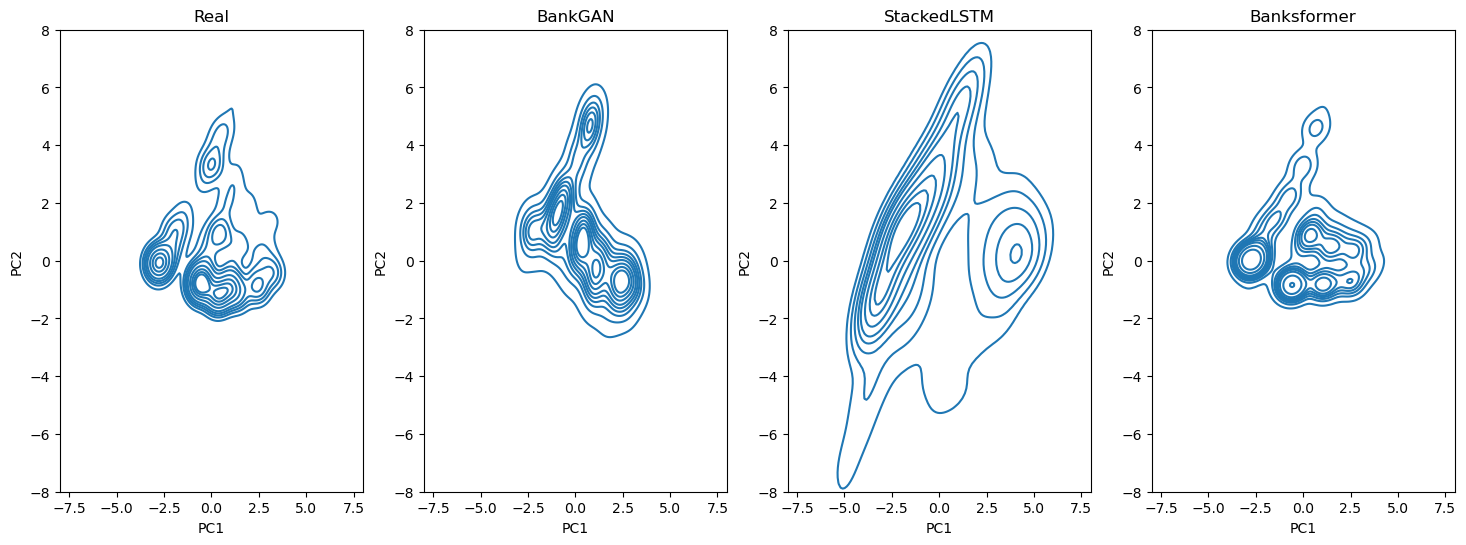

In [128]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1,4, figsize=(18, 6))
ax[0].set_ylim([-8,8])
ax[0].set_xlim([-8,8])
ax[1].set_ylim([-8,8])
ax[1].set_xlim([-8,8])
ax[2].set_ylim([-8,8])
ax[2].set_xlim([-8,8])
ax[3].set_ylim([-8,8])
ax[3].set_xlim([-8,8])

ax[0].set_title('Real')
ax[1].set_title('BankGAN')
ax[2].set_title('StackedLSTM')
ax[3].set_title('Banksformer')

sns.kdeplot(data=pcs_scaled_rec[pcs_scaled_rec["src"]=="real"], x="PC1", y="PC2",ax=ax[0])
sns.kdeplot(data=pcs_scaled_rec[pcs_scaled_rec["src"]=="BankGAN"], x="PC1", y="PC2",ax=ax[1])
sns.kdeplot(data=pcs_scaled_rec[pcs_scaled_rec["src"]=="StackedLSTM"], x="PC1", y="PC2",ax=ax[2])
sns.kdeplot(data=pcs_scaled_rec[pcs_scaled_rec["src"]=="Banksformer"], x="PC1", y="PC2",ax=ax[3])


plt.show()


### Visualize non-recurring

In [129]:
cols = tcode_names_norec + ["amount", "days_passed"]
scaler = StandardScaler()
scaled_seqs_r_norec = scaler.fit_transform(real_norec_seq_df[cols])
scaled_seqs_synthbf_norec = scaler.transform(synthbf_norec_seq_df[cols])
scaled_seqs_synthlstm_norec = scaler.transform(synthlstm_norec_seq_df[cols])
scaled_seqs_synthgan_norec = scaler.transform(synthgan_norec_seq_df[cols])
pca = PCA()

scaled_seqs_r_norec_pc = pca.fit_transform(scaled_seqs_r_norec)
scaled_seqs_synthbf_norec_pc = pca.transform(scaled_seqs_synthbf_norec)
scaled_seqs_synthlstm_norec_pc = pca.transform(scaled_seqs_synthlstm_norec)
scaled_seqs_synthgan_norec_pc = pca.transform(scaled_seqs_synthgan_norec)

In [130]:
df1_norec = pd.DataFrame.from_records(scaled_seqs_synthbf_norec_pc[:,:2], columns=["PC1", "PC2"])
df1_norec["src"] = "Banksformer"

df2_norec = pd.DataFrame.from_records(scaled_seqs_synthlstm_norec_pc[:,:2], columns=["PC1", "PC2"])
df2_norec["src"] = "StackedLSTM"

df3_norec = pd.DataFrame.from_records(scaled_seqs_synthgan_norec_pc[:,:2], columns=["PC1", "PC2"])
df3_norec["src"] = "BankGAN"

df4_norec = pd.DataFrame.from_records(scaled_seqs_r_norec_pc[:,:2], columns=["PC1", "PC2"])
df4_norec["src"] = "real"

pcs_scaled_norec = pd.concat([df1_norec, df2_norec, df3_norec, df4_norec]).reset_index()
pcs_scaled_norec

,index,PC1,PC2,src
0,0,-0.113791,-0.312987,Banksformer
1,1,1.644886,-0.380113,Banksformer
2,2,0.786062,0.543450,Banksformer
3,3,0.457378,-0.169487,Banksformer
4,4,0.983187,1.098696,Banksformer
...,...,...,...,...
19495,4495,1.415558,1.492046,real
19496,4496,-1.464268,-0.013114,real
19497,4497,-0.808677,-0.300901,real
19498,4498,0.346171,-0.288522,real


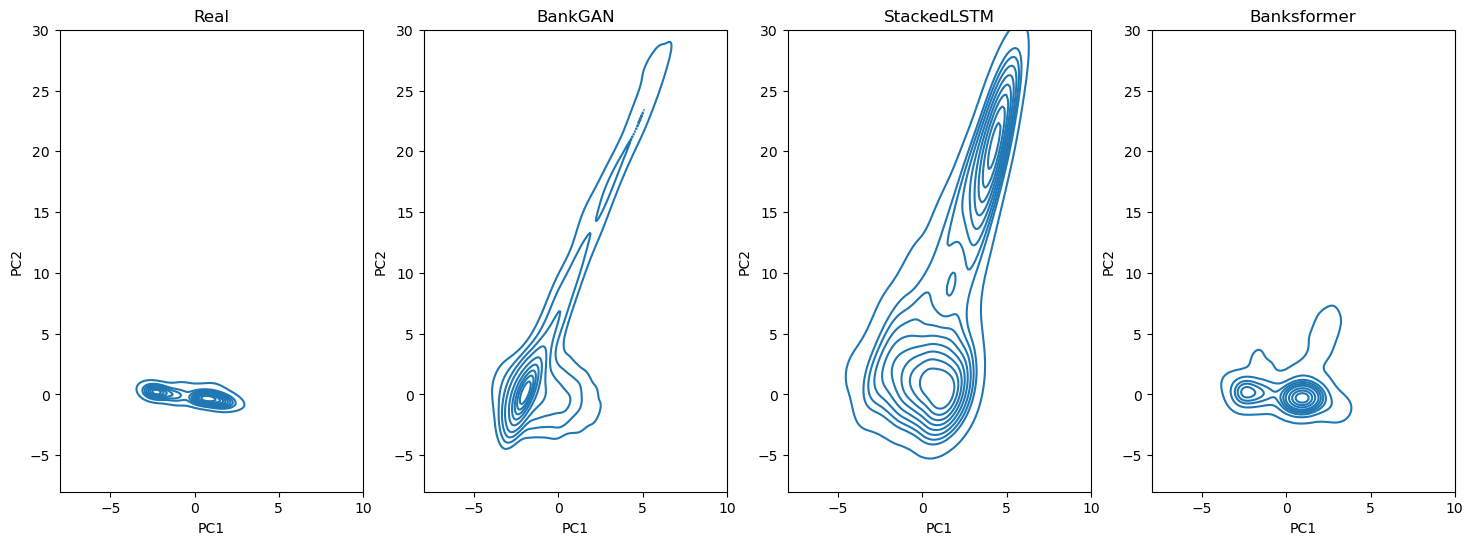

In [139]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1,4, figsize=(18, 6))
ax[0].set_ylim([-8,30])
ax[0].set_xlim([-8,10])
ax[1].set_ylim([-8,30])
ax[1].set_xlim([-8,10])
ax[2].set_ylim([-8,30])
ax[2].set_xlim([-8,10])
ax[3].set_ylim([-8,30])
ax[3].set_xlim([-8,10])

ax[0].set_title('Real')
ax[1].set_title('BankGAN')
ax[2].set_title('StackedLSTM')
ax[3].set_title('Banksformer')

sns.kdeplot(data=pcs_scaled_norec[pcs_scaled_norec["src"]=="real"], x="PC1", y="PC2",ax=ax[0])
sns.kdeplot(data=pcs_scaled_norec[pcs_scaled_norec["src"]=="BankGAN"], x="PC1", y="PC2",ax=ax[1])
sns.kdeplot(data=pcs_scaled_norec[pcs_scaled_norec["src"]=="StackedLSTM"], x="PC1", y="PC2",ax=ax[2])
sns.kdeplot(data=pcs_scaled_norec[pcs_scaled_norec["src"]=="Banksformer"], x="PC1", y="PC2",ax=ax[3])


plt.show()

### Visualize Entire

In [82]:
cols = tcode_names + ["amount", "days_passed"]
scaler = StandardScaler()
scaled_seqs_r = scaler.fit_transform(real_seq_df[cols])
scaled_seqs_synthbf = scaler.transform(synthbf_seq_df[cols])
scaled_seqs_synthlstm = scaler.transform(synthlstm_seq_df[cols])
scaled_seqs_synthgan = scaler.transform(synthgan_seq_df[cols])
pca = PCA()

scaled_seqs_r_pc = pca.fit_transform(scaled_seqs_r)
scaled_seqs_synthbf_pc = pca.transform(scaled_seqs_synthbf)
scaled_seqs_synthlstm_pc = pca.transform(scaled_seqs_synthlstm)
scaled_seqs_synthgan_pc = pca.transform(scaled_seqs_synthgan)

In [83]:
df1 = pd.DataFrame.from_records(scaled_seqs_synthbf_pc[:,:2], columns=["PC1", "PC2"])
df1["src"] = "Banksformer"

df2 = pd.DataFrame.from_records(scaled_seqs_synthlstm_pc[:,:2], columns=["PC1", "PC2"])
df2["src"] = "StackedLSTM"

df3 = pd.DataFrame.from_records(scaled_seqs_synthgan_pc[:,:2], columns=["PC1", "PC2"])
df3["src"] = "BankGAN"

df4 = pd.DataFrame.from_records(scaled_seqs_r_pc[:,:2], columns=["PC1", "PC2"])
df4["src"] = "real"

pcs_scaled = pd.concat([df1, df2, df3, df4]).reset_index()
pcs_scaled

,index,PC1,PC2,src
0,0,-0.978936,5.317552,Banksformer
1,1,-0.861335,-0.128547,Banksformer
2,2,-3.346078,-3.069449,Banksformer
3,3,0.314015,-1.807281,Banksformer
4,4,-1.400513,-2.595415,Banksformer
...,...,...,...,...
19495,4495,2.174026,-1.776924,real
19496,4496,1.150864,0.190708,real
19497,4497,-0.143802,1.170867,real
19498,4498,-0.354919,4.125385,real


In [70]:
data=pcs_scaled[pcs_scaled["src"]=="StackedLSTM"]
data

,index,PC1,PC2,src
5000,0,2.680033,-2.410737,StackedLSTM
5001,1,-1.669841,-0.126009,StackedLSTM
5002,2,0.972760,-3.205093,StackedLSTM
5003,3,-2.104259,-3.547034,StackedLSTM
5004,4,-0.009417,3.334446,StackedLSTM
...,...,...,...,...
9995,4995,3.960149,-0.718358,StackedLSTM
9996,4996,-0.308044,5.272703,StackedLSTM
9997,4997,0.565315,-2.270319,StackedLSTM
9998,4998,-0.694095,4.754669,StackedLSTM


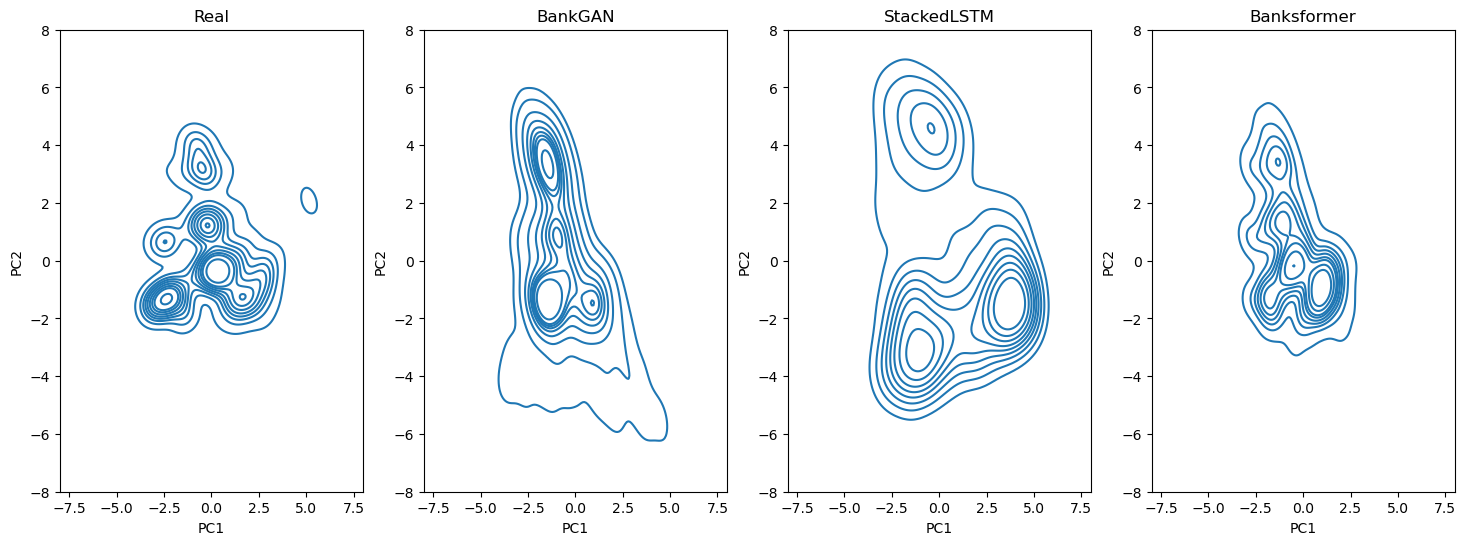

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1,4, figsize=(18, 6))
ax[0].set_ylim([-8,8])
ax[0].set_xlim([-8,8])
ax[1].set_ylim([-8,8])
ax[1].set_xlim([-8,8])
ax[2].set_ylim([-8,8])
ax[2].set_xlim([-8,8])
ax[3].set_ylim([-8,8])
ax[3].set_xlim([-8,8])

ax[0].set_title('Real')
ax[1].set_title('BankGAN')
ax[2].set_title('StackedLSTM')
ax[3].set_title('Banksformer')

sns.kdeplot(data=pcs_scaled[pcs_scaled["src"]=="real"], x="PC1", y="PC2",ax=ax[0])
sns.kdeplot(data=pcs_scaled[pcs_scaled["src"]=="BankGAN"], x="PC1", y="PC2",ax=ax[1])
sns.kdeplot(data=pcs_scaled[pcs_scaled["src"]=="StackedLSTM"], x="PC1", y="PC2",ax=ax[2])
sns.kdeplot(data=pcs_scaled[pcs_scaled["src"]=="Banksformer"], x="PC1", y="PC2",ax=ax[3])


plt.show()
